## Economic Forecasting Week 6
#### Draws from [this article](https://builtin.com/data-science/time-series-forecasting-python)
#### [Data](https://fred.stlouisfed.org/series/UNRATENSA)

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [41]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # to ignore all UserWarnings
warnings.filterwarnings("ignore", category=FutureWarning)  # to ignore all FutureWarnings

Load in my non-seasonally adjusted unemployment time series

From Chat


#### When to Use Seasonally Adjusted Data
- For Analyzing Trends and Cycles: If your goal is to understand underlying trends, cycles, or long-term growth patterns without seasonal fluctuations, then seasonally adjusted data is often preferable. Seasonal adjustments smooth out recurring patterns (like quarterly GDP spikes) to highlight the broader movement over time.
- For Long-Term Forecasting: Seasonally adjusted data may be more useful for long-term forecasting because it removes short-term seasonal "noise," making it easier to focus on trend and cyclical components.


#### When to Use Non-Seasonally Adjusted Data
- For Short-Term Forecasting: If you’re forecasting over a short period and want to capture detailed seasonal patterns (e.g., month-to-month or quarter-to-quarter fluctuations), non-seasonally adjusted data can be more informative. In this case, the model can explicitly learn and predict the seasonality in the data, which could enhance accuracy for short-term predictions.
- If Using Seasonal Models (e.g., SARIMA/SARIMAX): Seasonal models like SARIMA or SARIMAX are designed to handle non-seasonally adjusted data by capturing the seasonality patterns in the model. If your data has significant seasonal components, using non-seasonally adjusted data can allow these models to better learn and forecast those patterns.

In [10]:
unemployment = pd.read_csv("UNRATENSA.csv")
unemployment['DATE'] = pd.to_datetime(unemployment['DATE'])
unemployment.head()

,DATE,UNRATENSA
0,1948-01-01,4.0
1,1948-02-01,4.7
2,1948-03-01,4.5
3,1948-04-01,4.0
4,1948-05-01,3.4


Text(0.5, 1.0, 'Unemployment Rate over Time')

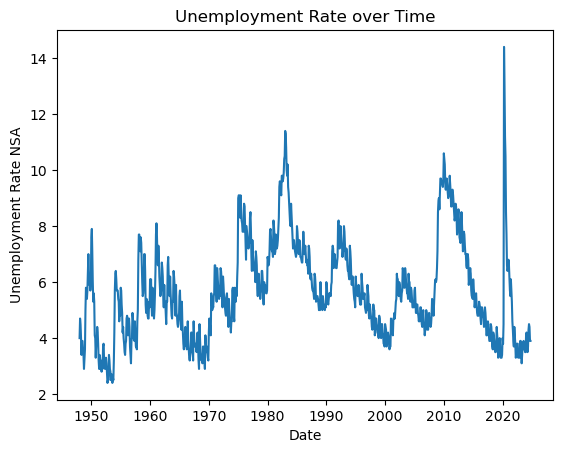

In [11]:
plt.plot(unemployment['DATE'], unemployment['UNRATENSA'])
plt.xlabel("Date")
plt.ylabel("Unemployment Rate NSA")
plt.title("Unemployment Rate over Time")

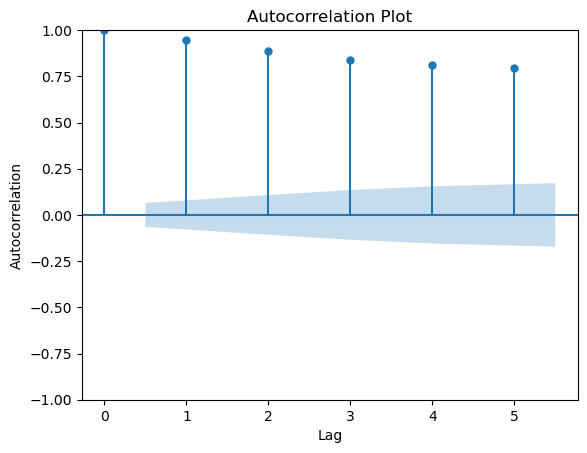

In [59]:
# Create the autocorrelation plot
plot_acf(unemployment['UNRATENSA'], lags=5)  # You can change 'lags' to specify the number of lags
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [15]:
# Randomly split the data into train and test sets (e.g., 80% train, 20% test)
train, test = train_test_split(unemployment, test_size=0.2, random_state=42)

# Sort the indices to maintain the time order for plotting
train = train.sort_index()
test = test.sort_index()

In [16]:
print(len(test))
print(len(train))
print(len(test) / len(train))

185
737
0.2510176390773406


### Autoregressive Integrated Moving Average (ARIMA) Model

- Has 3 parameters that we'll tune later

In [45]:
y = train['UNRATENSA']

## First time we run the model, just randomly assign the order parameters
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

arma_rmse = np.sqrt(mean_squared_error(test["UNRATENSA"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  2.532655260769981


Let's see if we can improve the RMSE of this model by tuning the following parameters
- p: The number of lag observations in the autoregressive (AR) part.
- d: The number of times the data needs to be differenced to make it stationary.
- q: The number of lagged forecast errors in the moving average (MA) part.

In [26]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(unemployment['UNRATENSA'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.0590117693646035
p-value: 0.029738988128092336


p-value < 0.05 --> reject the Null that the time series is non-stationary

--> set our d parameter = 0

In [46]:
ARIMAmodel = ARIMA(y, order = (2, 0, 2)) # p d q is the order
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

arma_rmse = np.sqrt(mean_squared_error(test["UNRATENSA"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  1.7160290323739429


Notice how this already decreased our RMSE by changing the d


Now, we can run a grid search and iterate over all possible values to tune the hyperparameters to optimal

In [58]:
from pmdarima import auto_arima

# Perform a grid search over (p, d, q) values
auto_model = auto_arima(y, start_p=0, start_q=0, max_p=5, max_q=5, d=0,
                        seasonal=False, trace=True, error_action='ignore',
                        suppress_warnings=True, stepwise=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4721.707, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3796.680, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1467.609, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1456.496, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3144.429, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1444.820, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1442.126, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1442.288, Time=0.31 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1441.297, Time=0.22 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1439.312, Time=0.32 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0

In [47]:
ARIMAmodel = ARIMA(y, order = (4, 0, 0)) # use (4,0,0), the result of our grid search
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

arma_rmse = np.sqrt(mean_squared_error(test["UNRATENSA"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  1.7147797833737823


It works!

### Seasonal ARIMA (SARIMA) Model

The seasonal_order parameter consists of four components:

- P: The number of seasonal autoregressive terms.
- D: The number of seasonal differences.
- Q: The number of seasonal moving average terms.
- s: The length of the seasonal cycle.

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# use the optimal order parameters from ARIMA, random seasonal
SARIMAXmodel = SARIMAX(y, order = (4, 0, 0), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

sarima_rmse = np.sqrt(mean_squared_error(test["UNRATENSA"].values, y_pred_df["Predictions"]))
print("RMSE: ",sarima_rmse)

RMSE:  2.6656340966049075


Let's do another grid search for the seasonal order parameters

In [52]:
# y is your time series data and test is your test dataset

# Define a function to evaluate different SARIMAX parameters
def evaluate_sarimax(y, order, seasonal_order):
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    return np.sqrt(mean_squared_error(test["UNRATENSA"], model_fit.get_forecast(len(test.index)).predicted_mean))

# Grid search for the best parameters
best_rmse = float('inf')
best_params = None

# Define ranges for seasonal parameters
P = range(0, 3)  # Example range for P
D = range(0, 2)  # Example range for D
Q = range(0, 3)  # Example range for Q
s = [12]  # Seasonal cycle length, e.g., monthly data has 12

for p in P:
    for d in D:
        for q in Q:
            seasonal_order = (p, d, q, s[0])
            try:
                rmse = evaluate_sarimax(y, order=(4, 0, 0), seasonal_order=seasonal_order)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = seasonal_order
            except Exception as e:
                print(f"Error with parameters {seasonal_order}: {e}")

print(f"Best RMSE: {best_rmse}")
print(f"Best seasonal parameters: {best_params}")


Best RMSE: 1.7293611820172823
Best seasonal parameters: (0, 1, 1, 12)


Big differences already!